# NET-seq TASEP Speed Benchmark

This notebook compares baseline Python TASEP code and optimized TASEP code using Numba JIT using the exact baseline default simulation parameters (geneLength=3075, uniform dwell profile).

Runs are executed in a machine with an Intel(R) Core(TM) i7-10750H CPU. The MATLAB code (sjkimlab_NETSEQ_TASEP.m) takes approximately ~4s per run for this parameter set.

In [1]:
import os
import shutil
import subprocess
import sys
import time
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

cwd = Path.cwd().resolve()
if (cwd / 'sjkimlab_NETSEQ_TASEP.py').exists():
    module_dir = cwd
elif (cwd / 'sjkimlab_NETSEQ_TASEP' / 'sjkimlab_NETSEQ_TASEP.py').exists():
    module_dir = cwd / 'sjkimlab_NETSEQ_TASEP'
else:
    raise FileNotFoundError('Could not locate sjkimlab_NETSEQ_TASEP.py from current working directory')

if str(module_dir) not in sys.path:
    sys.path.insert(0, str(module_dir))

from sjkimlab_NETSEQ_TASEP import netseq_tasep_function
from netseq_tasep_fast import (
    SNAPSHOTS,
    _worker,
    _worker_batch,
    netseq_tasep_fast,
)

SEED = 42
N_RUNS_BASELINE = 8
N_RUNS_SWEEP = 8

# Match the default parameter set used inside netseq_tasep_function exactly.
PARAMS = {
    'RNAPSpeed': 19,
    'ribospeed': 19,
    'kLoading': 1 / 20,
    'kRiboLoading': 0,
    'KRutLoading': 0.13,
    'simtime': 2000,
    'glutime': 1600,
    'geneLength': 3075,
    'RNAP_dwellTimeProfile': np.ones(3075, dtype=float),
}


def run_fast_with_params(n_runs: int, seed: int | None = None, n_workers: int | None = None) -> np.ndarray:
    if n_runs <= 0:
        raise ValueError('n_runs must be positive')

    base_seed = int(seed) if seed is not None else int(np.random.SeedSequence().generate_state(1)[0])
    seeds = [base_seed + i for i in range(n_runs)]

    if n_workers is None:
        n_workers = os.cpu_count() or 1
    n_workers = max(1, int(n_workers))

    if n_workers == 1:
        outputs = [_worker((PARAMS, s)) for s in seeds]
        total = np.zeros_like(outputs[0], dtype=float)
        for out in outputs:
            total += out
        return total / float(n_runs)

    n_batches = min(n_workers, n_runs)
    chunks = [chunk.tolist() for chunk in np.array_split(np.asarray(seeds, dtype=np.int64), n_batches)]
    worker_args = [(PARAMS, chunk) for chunk in chunks if len(chunk) > 0]

    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        partials = list(executor.map(_worker_batch, worker_args))

    total = np.zeros_like(partials[0], dtype=float)
    for part in partials:
        total += part
    return total / float(n_runs)


print(
    f'Configured baseline-default parameters: '
    f"geneLength={PARAMS['geneLength']}, "
    f"uniform_dwell={np.allclose(PARAMS['RNAP_dwellTimeProfile'], 1.0)}, "
    f"seed={SEED}"
)


Configured baseline-default parameters: geneLength=3075, uniform_dwell=True, seed=42


In [2]:
get_ipython().run_line_magic("matplotlib", "inline")
plt.switch_backend("module://matplotlib_inline.backend_inline")

In [3]:
# Dedicated JIT warm-up (single-process compile cost)
t0 = time.perf_counter()
_ = netseq_tasep_fast(PARAMS, seed=SEED)
jit_compile_time = time.perf_counter() - t0
print(f"JIT compile time: {jit_compile_time:.1f}s")
print("Note: worker processes may still pay their own first-call startup/JIT costs.")

JIT compile time: 5.6s
Note: worker processes may still pay their own first-call startup/JIT costs.


In [4]:
# Baseline single-run timing
rng = np.random.default_rng(SEED)
t0 = time.perf_counter()
baseline_single = netseq_tasep_function(PARAMS, rng)
t_baseline_single = time.perf_counter() - t0

net_single = np.asarray(baseline_single["NETseq"], dtype=float)
cols_single = [t - 1 for t in SNAPSHOTS if 1 <= t <= net_single.shape[1]]
baseline_single_sum = net_single[:, cols_single].sum(axis=1)

print(f"Baseline single run: {t_baseline_single:.3f}s")

Baseline single run: 5.944s


In [5]:
# Baseline n_runs=10 sequential timing
baseline_runs = []
t0 = time.perf_counter()
for i in range(N_RUNS_BASELINE):
    rng = np.random.default_rng(SEED + i)
    out = netseq_tasep_function(PARAMS, rng)
    net = np.asarray(out["NETseq"], dtype=float)
    cols = [t - 1 for t in SNAPSHOTS if 1 <= t <= net.shape[1]]
    baseline_runs.append(net[:, cols].sum(axis=1))
t_baseline_nruns = time.perf_counter() - t0
baseline_avg_nruns = np.mean(np.vstack(baseline_runs), axis=0)

print(f"Baseline n_runs={N_RUNS_BASELINE}: {t_baseline_nruns:.3f}s")

Baseline n_runs=8: 47.702s


In [6]:
# Fast single-run timing
t0 = time.perf_counter()
fast_single = netseq_tasep_fast(PARAMS, seed=SEED)
t_fast_single = time.perf_counter() - t0
fast_single_sum = np.asarray(fast_single["NETseq_sum"], dtype=float)

print(f"Fast single run: {t_fast_single:.3f}s")

Fast single run: 0.055s


In [7]:
# Worker-count sweep with explicit pre-warm per setting
worker_candidates = [1, 2, 4, os.cpu_count() or 1]
worker_values = []
for w in worker_candidates:
    if w not in worker_values:
        worker_values.append(w)

worker_times = {}
for w in worker_values:
    _ = run_fast_with_params(n_runs=1, seed=SEED, n_workers=w)  # untimed pre-warm
    t0 = time.perf_counter()
    _ = run_fast_with_params(n_runs=N_RUNS_SWEEP, seed=SEED, n_workers=w)
    worker_times[w] = time.perf_counter() - t0

print('Worker sweep timings (startup/JIT overhead pre-warmed per worker setting):')
for w in worker_values:
    print(f'  n_workers={w}: {worker_times[w]:.3f}s')


Worker sweep timings (startup/JIT overhead pre-warmed per worker setting):
  n_workers=1: 0.290s
  n_workers=2: 8.877s
  n_workers=4: 9.412s
  n_workers=12: 12.938s


In [8]:
# Aggregate wallclock summary
t_fast_nruns = worker_times.get(1)
variants = ["baseline_single", "baseline_n10", "fast_single", f"fast_n8_1worker"]
times = [t_baseline_single, t_baseline_nruns, t_fast_single, t_fast_nruns]

for name, val in zip(variants, times):
    print(f"{name}: {val:.3f}s")


baseline_single: 5.944s
baseline_n10: 47.702s
fast_single: 0.055s
fast_n8_1worker: 0.290s


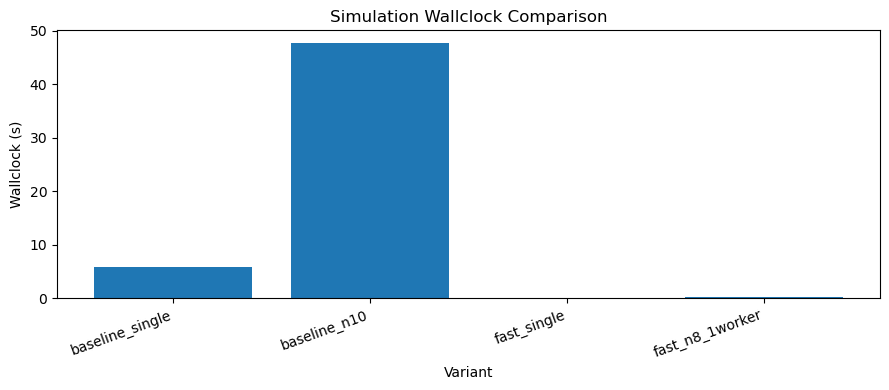

In [9]:
# Wallclock bar chart
plt.figure(figsize=(9, 4))
plt.bar(variants, times)
plt.ylabel("Wallclock (s)")
plt.xlabel("Variant")
plt.title("Simulation Wallclock Comparison")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()